In [1]:
from mmdet.apis import init_detector, inference_detector
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import matplotlib.colors as mcolors

In [2]:
#config = 'mmdet_configs/configs/faster_rcnn/faster_rcnn_r50_fpn_2x_coco.py'
#config = 'mmdet_configs/configs/yolo/yolov3_d53_fp16_mstrain-608_273e_coco.py'
config = 'cracks_tood.py'
#checkpoint = 'faster_rcnn_r50_fpn_2x_coco_bbox_mAP-0.384_20200504_210434-a5d8aa15.pth'
#checkpoint = 'yolov3_d53_fp16_mstrain-608_273e_coco_20210517_213542-4bc34944.pth'
checkpoint = 'tood.pth'
device = 'cuda:0'

In [3]:
model = init_detector(config, checkpoint, device)

load checkpoint from local path: tood.pth


2022-07-12 15:53:53,471 - root - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
2022-07-12 15:53:53,474 - root - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
2022-07-12 15:53:53,476 - root - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
2022-07-12 15:53:53,478 - root - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
2022-07-12 15:53:53,480 - root - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
2022-07-12 15:53:53,484 - root - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
2022-07-12 15:53:53,486 - root - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
2022-07-12 15:53:53,489 - root - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
2022-07-12 15:53:53,491 - root - INFO - ModulatedDeformConvPack backbone.layer3.4.conv2 

In [4]:
label_names=['Arrachement_pelade', 'Faiencage', 'Nid_de_poule',
                 'Transversale', 'Longitudinale', 'Reparation']

In [5]:
colors_list = [[1,0,0], [0,1,0], [0,0,1], [1,0,1], [0,1,1], [1,1,0]]
cmaps = []
for ic in range(len(label_names)):
    colors = [(colors_list[ic][0], colors_list[ic][1], colors_list[ic][2], c) for c in np.linspace(0,1,100)]
    cmaps.append( mcolors.LinearSegmentedColormap.from_list(f'mycmap{ic}', colors, N=5) )

In [7]:
def parse_yolo_annotation(annotation_txtpath):
    """ Parse a yolo annotation file. """
    annotations = []
    with open(annotation_txtpath, "rt") as f_in:
        for line in f_in.readlines():
            line = line.strip()

            cls, x_center, y_center, width, height = line.split()

            annotations.append(
                {
                    "class_index": int(cls),
                    "x_center": float(x_center),
                    "y_center": float(y_center),
                    "width": float(width),
                    "height": float(height),
                }
            )
    return annotations


def yolo_annotations_to_box(yolo_annotations, image, label_names):
    """ Convert a yolo annotation list to (x1, y1, x2, y2) coordinates."""
    image_width = image.shape[1]
    image_height = image.shape[0]
    box_annotations = [[] for _ in range(len(label_names))]

    for annotation in yolo_annotations:
        x1 = int(round((annotation["x_center"]-annotation['width']/2) * image_width))
        if x1 < 0:
            x1 = 0
        y1 = int(round((annotation["y_center"]-annotation['height']/2) * image_height))
        if y1 < 0:
            y1 = 0
        x2 = int(round((annotation["x_center"]+annotation['width']/2) * image_width))
        y2 = int(round((annotation["y_center"]+annotation['height']/2) * image_height))
        box_annotations[annotation['class_index']].append([x1,y1,x2,y2])

    for c in range(len(label_names)):
        if len(box_annotations[c]) > 0:
            box_annotations[c] = np.stack(box_annotations[c])

    return box_annotations

In [8]:
def generate_mask(image_size, grid_size, prob_thresh):
    image_w, image_h = image_size
    grid_w, grid_h = grid_size
    cell_w, cell_h = math.ceil(image_w / grid_w), math.ceil(image_h / grid_h)
    up_w, up_h = (grid_w + 1) * cell_w, (grid_h + 1) * cell_h

    mask = (np.random.uniform(0, 1, size=(grid_h, grid_w)) <
            prob_thresh).astype(np.float32)
    mask = cv2.resize(mask, (up_w, up_h), interpolation=cv2.INTER_LINEAR)
    offset_w = np.random.randint(0, cell_w)
    offset_h = np.random.randint(0, cell_h)
    mask = mask[offset_h:offset_h + image_h, offset_w:offset_w + image_w]
    return mask

In [9]:
def mask_image(image, mask):
    masked = ((image.astype(np.float32) / 255 * np.dstack([mask] * 3)) *
              255).astype(np.uint8)
    return masked

In [10]:
def iou(boxes, box):
    box = np.asarray(box)
    tl = np.maximum(boxes[:,:2], box[:2])
    br = np.minimum(boxes[:,2:], box[2:])
    intersection = np.prod(br - tl, axis=1) * np.all(tl < br, axis=1).astype(float)
    area1 = np.prod(boxes[:,2:] - boxes[:,:2], axis=1)
    area2 = np.prod(box[2:] - box[:2])
    return intersection / (area1 + area2 - intersection)

In [11]:
def generate_saliency_map(image,
                          n_classes,
                          target_boxes,
                          prob_thresh=0.5,
                          grid_size=(16, 16),
                          n_masks=5000,
                          seed=0):
    np.random.seed(seed)
    image_h, image_w = image.shape[:2]
    res = [
            [np.zeros((image_h, image_w), dtype=np.float32) for _ in range (len(target_boxes[ic]))]
            for ic in range(n_classes)
    ]
    for i in tqdm.notebook.tqdm(range(n_masks)):
        mask = generate_mask(image_size=(image_w, image_h),
                             grid_size=grid_size,
                             prob_thresh=prob_thresh)
        masked = mask_image(image, mask)
        out = inference_detector(model, masked)
        for ic in range(n_classes):
            boxes = target_boxes[ic]
            pred = out[ic]
            if len(pred) > 0 and len(boxes) > 0:
                score = np.stack([iou(boxes, box) * score for *box, score in pred]).max(axis=0)
                for ib in range(len(target_boxes[ic])):
                    res[ic][ib] += mask * score[ib]
    return res

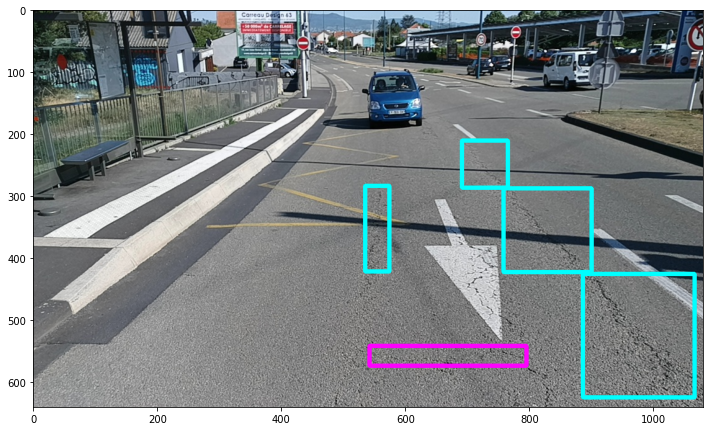

In [63]:
image_path = 'images/no_contract_xavier_nx_20220511_135505_770_000731.jpg'

image = cv2.imread(image_path)
#scale = 600 / min(image.shape[:2])
#image = cv2.resize(image,
#                   None,
#                   fx=800 / image.shape[1],
#                   fy=640 / image.shape[0],
#                   interpolation=cv2.INTER_AREA)

yolo_ann = parse_yolo_annotation(image_path.replace('.jpg', '.txt'))
target_boxes = yolo_annotations_to_box(yolo_ann, image, label_names)

res = image.copy()
for ic in range(len(label_names)):
    for i in range(len(target_boxes[ic])):
            cv2.rectangle(res, target_boxes[ic][i,:2], target_boxes[ic][i, 2:],
                          (np.flip(np.array(colors_list[ic])*255)).tolist(), 5)
            
plt.figure(figsize=(12, 12))
plt.imshow(res[:, :, ::-1])
plt.show()

1 Faiencage (686, 376, 768, 536) 0.46438107
4 Longitudinale (882, 421, 1077, 635) 0.79583186
4 Longitudinale (747, 274, 887, 419) 0.670574
4 Longitudinale (685, 205, 765, 288) 0.66944695
4 Longitudinale (520, 278, 576, 471) 0.47153834
4 Longitudinale (741, 535, 845, 637) 0.46473265


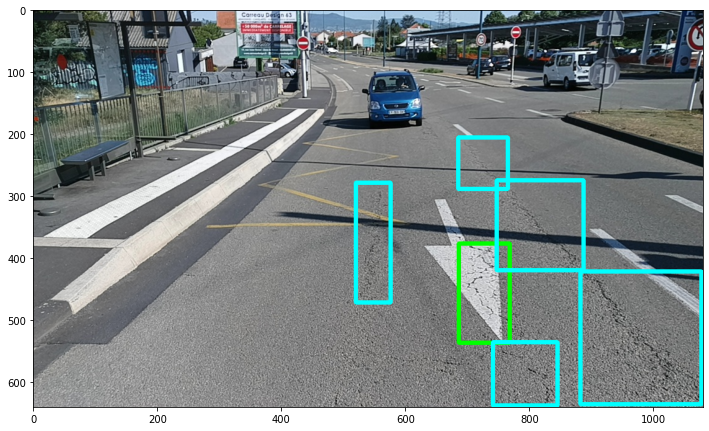

In [64]:
out = inference_detector(model, image)
res = image.copy()
pred_boxes = [[] for _ in range(len(label_names))]
for i, pred in enumerate(out):
    for *box, score in pred:
        if score < 0.3:
            continue
        box = tuple(np.round(box).astype(int).tolist())
        print(i, label_names[i], box, score)
        pred_boxes[i].append(box)
        cv2.rectangle(res, box[:2], box[2:], (np.flip(np.array(colors_list[i])*255)).tolist(), 5)
    if len(pred_boxes[i]) > 0:
        pred_boxes[i] = np.stack(pred_boxes[i])

plt.figure(figsize=(12, 12))
plt.imshow(res[:, :, ::-1])
plt.show()

In [60]:
saliency_map = generate_saliency_map(image,
                                     n_classes=len(label_names),
                                     target_boxes=target_boxes,
                                     prob_thresh=0.5,
                                     grid_size=(16, 16),
                                     n_masks=500)

  0%|          | 0/500 [00:00<?, ?it/s]

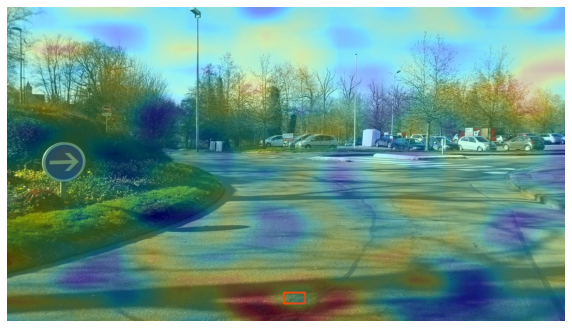

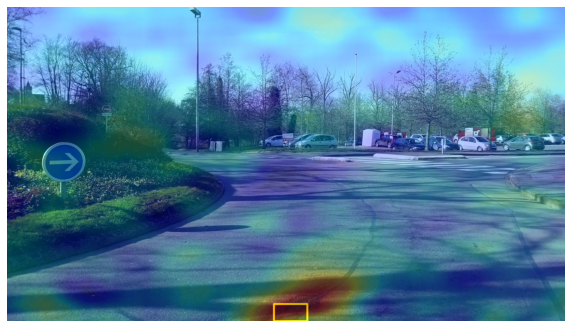

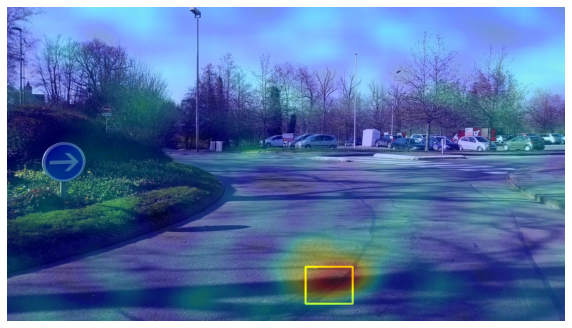

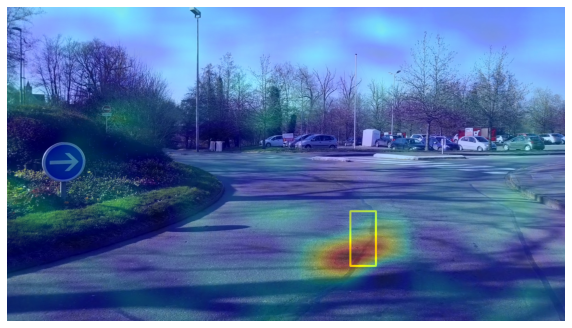

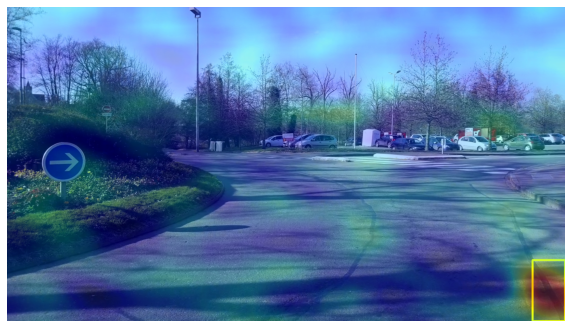

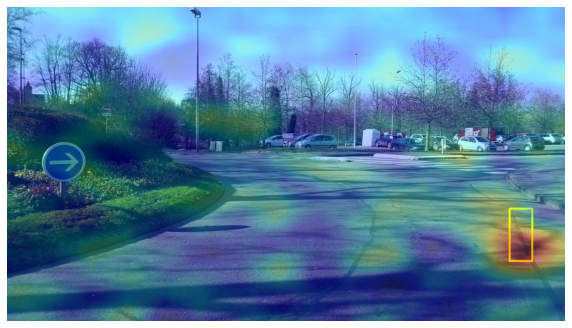

In [61]:
for ic, boxes in enumerate(target_boxes):
    for ib in range(len(boxes)):
        image_with_bbox = image.copy()
        cv2.rectangle(image_with_bbox, tuple(boxes[ib, :2]),
                      tuple(boxes[ib, 2:]), (np.flip(np.array(colors_list[ic])*255)).tolist(), 5)

        plt.figure(figsize=(10, 8))
        plt.imshow(image_with_bbox[:, :, ::-1])

        plt.imshow(saliency_map[ic][ib], cmap='jet', alpha=0.3)

        plt.axis('off')
        plt.show()

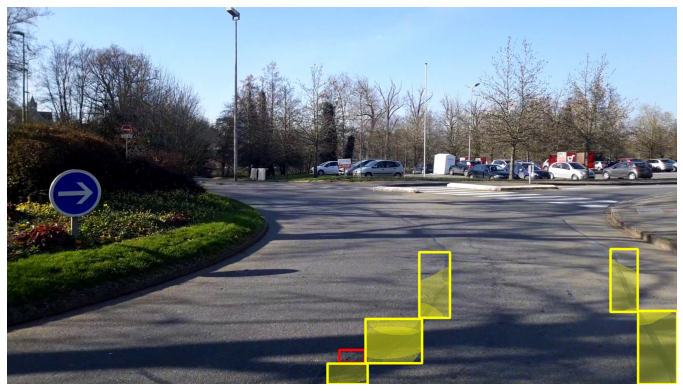

In [62]:
image_with_bbox = image.copy()
for ic in range(len(label_names)):
    for i in range(len(target_boxes[ic])):
        cv2.rectangle(image_with_bbox, tuple(target_boxes[ic][i,:2]),
                      tuple(target_boxes[ic][i,2:]), (np.flip(np.array(colors_list[ic])*255)).tolist(), 5)
        
plt.figure(figsize=(12, 12))
plt.imshow(image_with_bbox[:, :, ::-1])

seg_map = np.zeros((image.shape[0], image.shape[1])) # for annotation file

for ic in range(len(label_names)):
    if len(target_boxes[ic]) == 0:
        continue

    # keep segmentation map within annotated bboxes
    box_mask = np.full(saliency_map[ic][0].shape, False)
    for x1,y1,x2,y2 in target_boxes[ic]:
        box_mask[y1:y2+1, x1:x2+1] = True

    for ib in range(len(target_boxes[ic])):
        score_mask = saliency_map[ic][ib]>np.percentile(saliency_map[ic][ib], 98)
        segmentation_mask = score_mask & box_mask

        plt.imshow(segmentation_mask, cmap=cmaps[ic], alpha=0.3)
        seg_map = np.where(segmentation_mask, ic+1, seg_map) # for annotation file
    
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


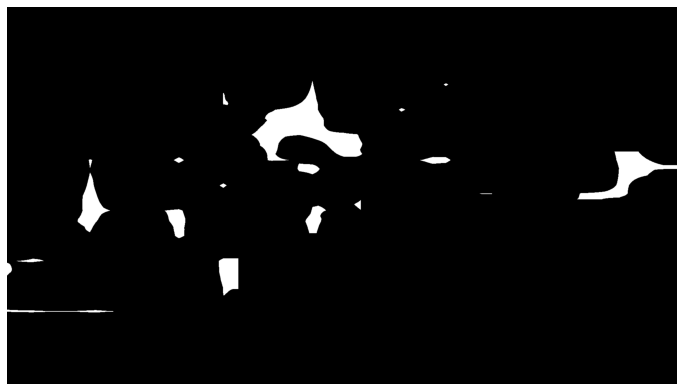

True

In [58]:
seg_map = np.transpose(np.stack([seg_map,seg_map,seg_map]), (1,2,0))
plt.figure(figsize=(12, 12))
plt.imshow(seg_map)
plt.axis('off')
plt.show()

cv2.imwrite('test.png', seg_map)

In [7]:
image_path = '/home/theo/Téléchargements/no_contract_xavier_nx_20220511_135505_770_001021.jpg'

image = cv2.imread(image_path)

seg_annot = cv2.imread('/home/theo/Téléchargements/no_contract_xavier_nx_20220511_135505_770_001021.png')
seg_annot = cv2.resize(seg_annot,
                   None,
                   fx= image.shape[1] / seg_annot.shape[1],
                   fy= image.shape[0] / seg_annot.shape[0],
                   interpolation=cv2.INTER_NEAREST)

#image_with_seg = image.copy()
#image_with_seg = cv2.resize(image_with_seg,
#                           None,
#                           fx=1920 / image.shape[1],
#                           fy=1080 / image.shape[0],
#                           interpolation=cv2.INTER_AREA)

4
6


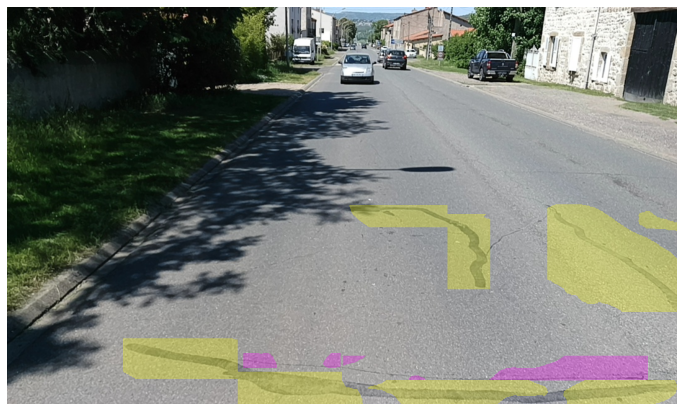

In [8]:
plt.figure(figsize=(12, 12))
plt.imshow(image[:, :, ::-1])
seg = seg_annot[:,:,0]

for ic in np.unique(seg):
    if ic == 0:
        continue
    seg_tmp = np.where(seg==ic, True, False)
    if seg_tmp.sum()>0:
        print(ic)
    plt.imshow(seg_tmp, cmap=cmaps[ic-1], alpha=0.3)
    
plt.axis('off')
plt.show()

In [9]:
seg_annot = cv2.resize(seg_annot,
                   None,
                   fx= 1920 / seg_annot.shape[1],
                   fy= 1080 / seg_annot.shape[0],
                   interpolation=cv2.INTER_NEAREST)

In [12]:
cv2.imwrite('test.png', cv2.cvtColor(seg_annot, cv2.COLOR_BGR2GRAY))

True